# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [2]:
# configs.
%matplotlib inline

model_id = "2.1.b.2.f - 060"

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1.a - df_test 04-19to05-19.feather', '1.1 - df_test 04-19to04-19.feather', '1.1.a - df_train  without nulls.feather', '1.1.a - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.1.b - 01-17 to 01-19 - df_val 01-19to03-19.feather', '1.1.a - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1 - df_train only 2018 without nulls.feather', '1.1 - df_train with nan.feather', '1.1.a - df_train only 2018 without nulls.feather', '1.1.a - df_train with nan.feather']


## Loading training and validation datasets

In [65]:
df = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather"))
df_val = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [66]:
# Select all non 060 tipo exped.
df = df[df["TIPO_EXPED"] == 6]
df_val = df_val[df_val["TIPO_EXPED"] == 6]

In [67]:
df["TIPO_EXPED"].value_counts()

6    32020
Name: TIPO_EXPED, dtype: int64

In [68]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [69]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [70]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [71]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [72]:
# using only last year
df_train = df[df["FECHA_SINI"] < "2018-11-01"].copy()
df_opt = df[df["FECHA_SINI"] >= "2018-11-01"].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-01-01 00:00:00 2018-10-31 00:00:00
2018-11-01 00:00:00 2019-01-31 00:00:00


In [73]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.73947532792005, 0.26052467207995)

In [74]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [75]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST", "es_gte_5"]

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [76]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [77]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [78]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

23678, 8342
23678, 8342


In [79]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.042359996621336264, 0.062095420762407094)

In [80]:
y_train.value_counts(dropna=False)

False    22675
True      1003
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [81]:
from sklearn.utils.class_weight import compute_class_weight

In [82]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([ 0.52493524, 10.52596976])

In [83]:
rf_params = {
    "n_estimators": [200],  # 100, 400
    "min_samples_leaf": [15, 21, 27], # , 65
     "max_depth": [10,  15, 30], # 10,
#    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:10}, {0:1, 1:18}, {0:1, 1:15}] 
}

In [84]:
# using without grid with list of models
rfs = []
# rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rf.fit(X_full_train, y_full_train)

In [85]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "f1"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=rf_params, seed=random_state)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf.best_estimator_))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Comparing 27 parameter setting(s) using 8 CPU thread(s) ( 3 job(s) per thread ).


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

Best score: 0.4315886134067952
Best config: {'class_weight': {0: 1, 1: 15}, 'max_depth': 15, 'min_samples_leaf': 21, 'n_estimators': 200}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


In [86]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=21,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False) 0.4315886134067952


In [87]:
sorted_ids = np.argsort(clf.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (clf.scores[i], clf.params[i]))

Grid scores:
0.432 for {'class_weight': {0: 1, 1: 15}, 'max_depth': 15, 'min_samples_leaf': 21, 'n_estimators': 200}
0.427 for {'class_weight': {0: 1, 1: 15}, 'max_depth': 15, 'min_samples_leaf': 15, 'n_estimators': 200}
0.423 for {'class_weight': {0: 1, 1: 15}, 'max_depth': 30, 'min_samples_leaf': 15, 'n_estimators': 200}
0.423 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 10, 'min_samples_leaf': 27, 'n_estimators': 200}
0.422 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 10, 'min_samples_leaf': 21, 'n_estimators': 200}
0.420 for {'class_weight': {0: 1, 1: 15}, 'max_depth': 10, 'min_samples_leaf': 21, 'n_estimators': 200}
0.417 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 30, 'min_samples_leaf': 15, 'n_estimators': 200}
0.417 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 15, 'min_samples_leaf': 21, 'n_estimators': 200}
0.416 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 15, 'min_samples_leaf': 15, 'n_estimators': 200}
0.414 for {'class_weight': {0: 1, 1: 18}, 'max_dept

In [88]:
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=21,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [89]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4393673110720563, 0.7135912902415061)

In [90]:
confusion_matrix(y_val, y_val_pred)

array([[4689,  174],
       [ 145,  125]])

**old**

In [33]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4754316069057105, 0.8002250554070418)

In [34]:
confusion_matrix(y_val, y_val_pred)

array([[4559,  304],
       [  91,  179]])

## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worst</h3>

In [110]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':clf.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
9,cond_C10,0.219234
29,total_condicion,0.161892
82,OCUPACION_ASEG,0.035628
10,cond_C11,0.028382
81,METRO,0.028352
53,preg_33,0.026880
6,cond_32,0.025364
52,preg_32,0.024247
77,FALTANTE,0.022589
73,DESCRIPCION_TIPO,0.019022


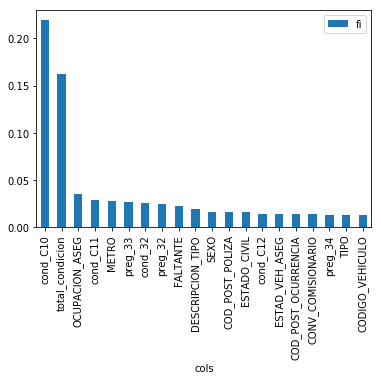

In [111]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [112]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 45 of 142


In [113]:
to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep

['cond_C10',
 'total_condicion',
 'OCUPACION_ASEG',
 'cond_C11',
 'METRO',
 'preg_33',
 'cond_32',
 'preg_32',
 'FALTANTE',
 'DESCRIPCION_TIPO',
 'SEXO',
 'COD_POST_POLIZA',
 'ESTADO_CIVIL',
 'cond_C12',
 'ESTAD_VEH_ASEG',
 'COD_POST_OCURRENCIA',
 'CONV_COMISIONARIO',
 'preg_34',
 'TIPO',
 'CODIGO_VEHICULO',
 'CAPITAL_ASEGURADO_COTIZACION',
 'CAPITAL_VEHICULO',
 'COD_PROD',
 'FECHA_SINI_Month',
 'FECHA_SINI_Dayofweek',
 'FECHA_SINI_Week',
 'SEGMENTO',
 'FECHA_SINI_Elapsed',
 'TIPO_SINIESTRO',
 'FECHA_SINI_Dayofyear',
 'FECHA_SINI_Day',
 'COD_COBRO_ANTERIOR',
 'MCA_AGRAVANTE',
 'COD_ZONA_ROBO',
 'COD_RAMO_sini',
 'preg_31',
 'preg_15',
 'CAPITAL_ACCESORIOS',
 'PRENDARIO',
 'COD_ZONA_RC',
 'NEGOCIO',
 'CANT_RENOVACION',
 'ANTIG_pol',
 'COD_COBRO',
 'MCA_VIP']

In [114]:
# best model
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=21,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [115]:
X_train_red = X_train[to_keep].copy()

In [116]:
print(len(X_train_red.columns))

45


### Training again with less features

In [117]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=21,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [118]:
y_val_pred = rf.predict(X_opt[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_opt, y_val_pred), roc_auc_score(y_opt, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.455162019593067, 0.7591054847573252)

In [119]:
confusion_matrix(y_opt, y_val_pred)

array([[7317,  507],
       [ 216,  302]])

In [120]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
0,cond_C10,0.222459
1,total_condicion,0.135309
2,OCUPACION_ASEG,0.035195
3,cond_C11,0.030998
5,preg_33,0.029395
4,METRO,0.026033
8,FALTANTE,0.025117
7,preg_32,0.024919
6,cond_32,0.020865
11,COD_POST_POLIZA,0.018741


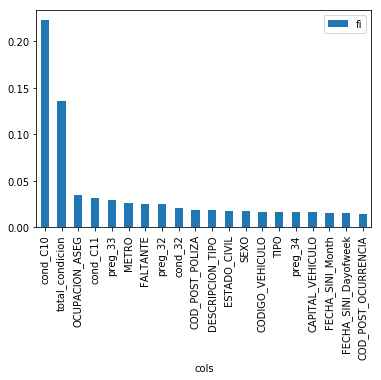

In [121]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# final model

In [ ]:
# reset_rf_samples()

## full features final model

In [126]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=21,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [127]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.425, 0.887


In [128]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4384,  479],
       [  68,  202]])

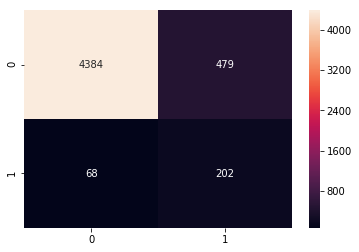

In [129]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [122]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=21,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [123]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.411, 0.884


In [124]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4387,  476],
       [  77,  193]])

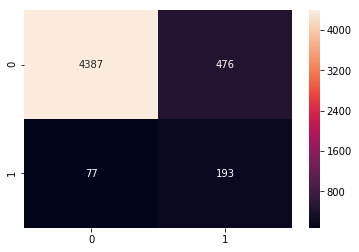

In [125]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [59]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.470873786407767,0.8222450704868967)


In [60]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[4503,  360],
       [  76,  194]])

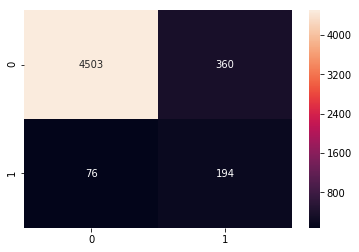

In [61]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [51]:
path_to_save = "../../src/models/1.1 - df_train 01-18to12-18/"
model_file = os.path.join(path_to_save, f"{model_id}(Model) - Model Optimization {metric} - class_weight {(rf_full.class_weight[0], rf_full.class_weight[1])} - time sorted - valid score ({metric_results}).pickle")

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [52]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [53]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['cond_C10', 'TIPO_EXPED', 'preg_15', 'es_gte_5', 'preg_31', 'preg_33', 'cond_32', 'preg_32', 'cond_C11', 'cond_C12', 'cond_C2', 'METRO', 'SEXO_TERC', 'OCUPACION_ASEG', 'FALTANTE', 'preg_34', 'cond_C5']


In [54]:
path_to_save = "../../src/features/1.1 - df_train 01-18to12-18/"
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - features: {len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [81]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [55]:
df_test = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [56]:
# Loding the model

def load_model(file_name):
    """Load the dump model."""
    folder = "models"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    model_file = os.path.join(path_to_load, file_name)

    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(file_name):
    """Load the array of columns use in the dump model."""
    folder = "features"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    columns_file = os.path.join(path_to_load, file_name)

    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [57]:
model_name = "1.1.b.2.f(Model) - Model Optimization recall - class_weight (1, 18) - time sorted - valid score (0.403, 0.972).pickle"
columns_name = "1.1.b.2.f (COLUMNS) - features: 17.pickle"
m = load_model(model_name)
columns = load_columns(columns_name)

In [59]:
X_test = df_test.loc[:, columns]
y_test = df_test["EXISTE_FRAUDE"]

In [60]:
X_test.head()

,cond_C10,TIPO_EXPED,preg_15,es_gte_5,preg_31,preg_33,cond_32,preg_32,cond_C11,cond_C12,cond_C2,METRO,SEXO_TERC,OCUPACION_ASEG,FALTANTE,preg_34,cond_C5
0,-1.0,3,-1,False,-1,-1,-1.0,-1,-1.0,-1.0,-1.0,1,-1,44.0,1,-1,-1.0
1,-1.0,3,-1,False,-1,-1,-1.0,-1,-1.0,-1.0,-1.0,1,-1,5.0,1,-1,-1.0
2,-1.0,5,-1,False,-1,-1,-1.0,1,-1.0,-1.0,3.0,1,-1,44.0,1,-1,0.0
3,-1.0,2,-1,False,-1,-1,-1.0,-1,-1.0,-1.0,-1.0,0,1,44.0,1,-1,-1.0
4,-1.0,3,-1,False,-1,-1,-1.0,-1,-1.0,-1.0,-1.0,0,-1,44.0,1,-1,-1.0


## Model in test

In [61]:
y_test_pred_prob = m.predict_proba(X_test)[:, -1]
print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.355, 0.989


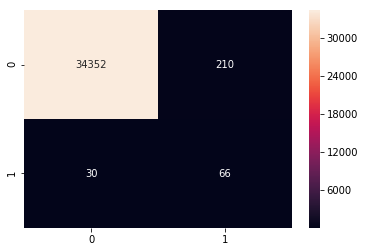

In [62]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador in test

In [63]:
y_tronador = X_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.330, 0.851


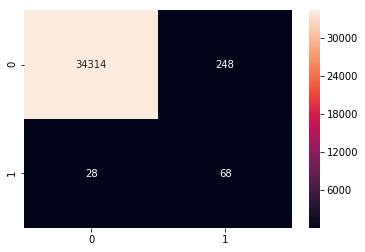

In [64]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")